In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import logging
logging.getLogger('tensorflow').disabled = True


import numpy as np
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

import tensorflow as tf
import tensorflow_probability as tfp

import transport_nets as tn

from transport_nets.models.NVP import NVP
from transport_nets.bijectors import BananaMap, BananaFlow
from transport_nets.mcmc import MetropolisHastings, model_log_prob

tfd = tfp.distributions
tfb = tfp.bijectors

## Train the Normalizing Flow
First, we train the flow to map a double banana distribution to a guassian. The end goal is to perform conditional sampling using MCMC along a part of the distribution where we cross 2 different 'modes'. 

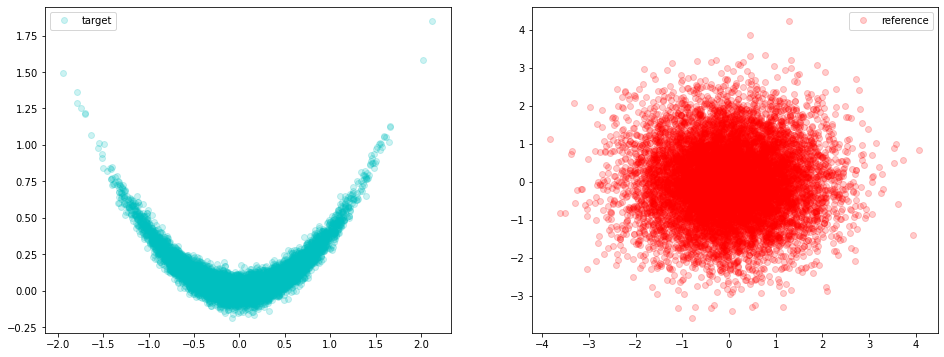

In [2]:
# Distrubtion that we want to learn to map to gaussian 
num_samples = 10000
params = (0.5,0.1,0.05,0.0)
bMap = BananaMap(params)
bFlow = BananaFlow(bMap)
target = bFlow.sample(num_samples)
latent = tf.random.normal([num_samples,2],mean=0.0,stddev=1.0)

# Plot them
fig,ax = plt.subplots(1,2,figsize=(16, 6))
ax[0].plot(target[:,0], target[:,1], 'co', alpha = .2,label='target')
ax[0].legend()
ax[1].plot(latent[:,0], latent[:,1], 'ro', alpha = .2,label='reference')
ax[1].legend();

### Define an NVP-based normalizing flow

In [3]:
# Create model object
nvp = NVP(output_dim=2,num_layers=4,num_masked=1, neuron_list=[20,20])

# Create optimizer and compile nvp with it
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08)
nvp.compile(opt)

# Perform a forward pass to initialize variables
_ = nvp(latent)

### Print a summary of the model

In [4]:
nvp.summary()

Model: "NVP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 2,020
Trainable params: 2,020
Non-trainable params: 0
_________________________________________________________________


### Train the model using ADAM

In [5]:
# Define training options
n_epochs = 50
batch_size = 100

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=num_samples).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
history = nvp.fit(dataset, epochs=n_epochs, verbose=0, callbacks=[TqdmCallback(verbose=1)])  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)
nvp.save_weights('models/nvp/weights.h5py')
nvp.save_model('models/nvp/model.h5py')

### Plot the training history

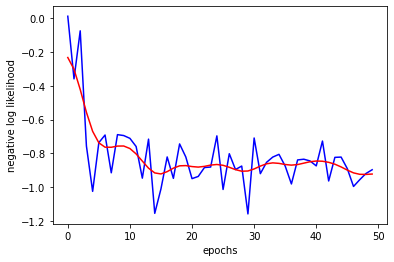

In [6]:
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(history.history['Negative Log Likelihood'], sigma=2)
plt.plot(history.history['Negative Log Likelihood'],'b')
plt.plot(ysmoothed, color = 'r')
plt.xlabel('epochs')
plt.ylabel('negative log likelihood');

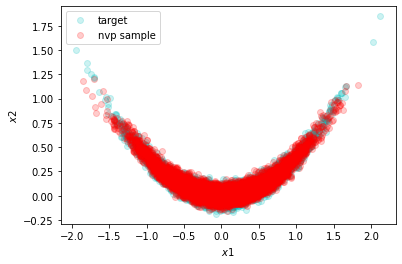

In [7]:
# Plot to make sure it worked
forward_pass = nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(target[:,0], target[:,1], 'co', alpha = .2,label='target')
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2,label='nvp sample')
plt.xlabel('$x1$')
plt.ylabel('$x2$')
plt.legend();

## Conditional Sampling using Metropolis Hastings

In [25]:
x_obs_list = [0.5,0.2,0.0]
niters = 5000
cond_samples = np.zeros((niters+1,3))
b_vals = [1.0,0.5,0.5]
acc_rate_list =[]
time_list = []
for i,val in enumerate(x_obs_list):
    # Run the algorithm
    init_val = tf.zeros([1],tf.float32)
    b = tf.constant(b_vals[i],tf.float32)
    
    y_given = tf.constant([val])
    log_prob_fn = model_log_prob(nvp,y_given=y_given)

    samples,acc_rate,total_time = MetropolisHastings(init_val,b,niters,log_prob_fn)
    print('acceptance rate: %0.3f'%acc_rate,'time:',total_time)
    cond_samples[:,i] = samples[:,0]
    acc_rate_list.append(acc_rate)
    time_list.append(total_time)

  0%|          | 0/5000 [00:00<?, ?it/s]

acceptance rate: 0.095 time: 48.210065841674805


  0%|          | 0/5000 [00:00<?, ?it/s]

acceptance rate: 0.257 time: 46.78582286834717


100%|██████████| 5000/5000 [00:45<00:00, 109.36it/s]

acceptance rate: 0.495 time: 45.72324252128601


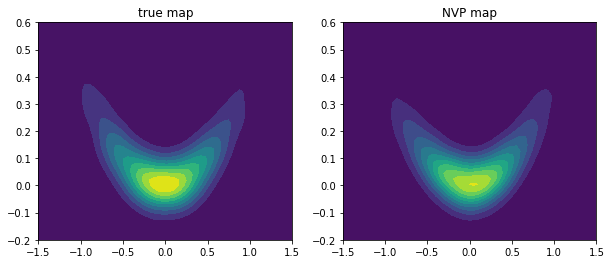

In [23]:
import seaborn as sns
def plot_density(data,axis):
    x, y = np.squeeze(np.split(data, 2, axis=1))
    return sns.kdeplot(x, y, cmap="viridis", shade=True, 
                     shade_lowest=True, ax=axis)
xa,xb,ya,yb = (-1.5,1.5,-0.2,0.6)
fig,ax = plt.subplots(1,2,figsize=(10,4))
X = bFlow.sample(5000)
X2 = nvp.sample(5000)
l1 = plot_density(X,axis=ax[0])
l2 = plot_density(X2,axis=ax[1])
ax[0].set(xlim=(xa,xb),ylim=(ya,yb))
ax[1].set(xlim=(xa,xb),ylim=(ya,yb))

ax[0].set_title('true map')
ax[1].set_title('NVP map')
plt.savefig('NVP_kde.png')

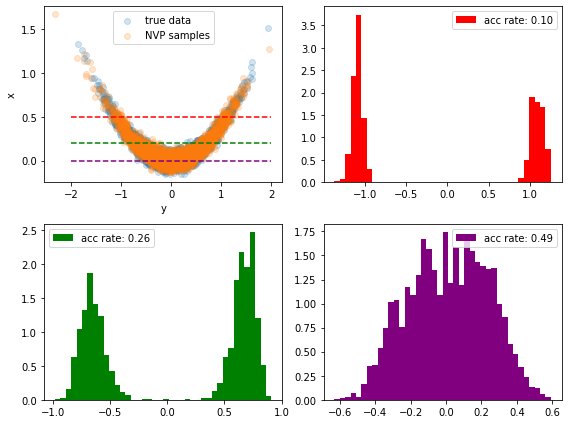

In [26]:
fig, ax = plt.subplots(2,2,figsize=(8,6))
x_obs_list = [0.5,0.2,0.0]

ax[0,0].scatter(X[:,0],X[:,1],alpha=0.2,label='true data')
ax[0,0].scatter(X2[:,0],X2[:,1],alpha=0.2,label='NVP samples')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[0]*np.ones(100),'r--')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[1]*np.ones(100),'g--')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[2]*np.ones(100),'--',c='purple')
ax[0,0].set(xlabel='y',ylabel='x')
ax[0,0].legend()

Ns = 2000
u = tf.random.normal([Ns,1])

ax[0,1].hist(cond_samples[:,0],40,color='r',density=True,label='acc rate: %0.2f'%(acc_rate_list[0]))
ax[0,1].legend()
ax[1,0].hist(cond_samples[:,1],40,color='g',density=True,label='acc rate: %0.2f'%(acc_rate_list[1]))
ax[1,0].legend()
ax[1,1].hist(cond_samples[:,2],40,color='purple',density=True,label='acc rate: %0.2f'%(acc_rate_list[2]))
ax[1,1].legend()
plt.tight_layout()
plt.savefig('NVP_MH_conditional_samples.png')